## Convocatoria 1 - Proyecto 1
#### Estudiante: Mayra Orellana
#### Url Git Hub: 
 https://github.com/mayralexaorellana/aprendizaje_supervisado/blob/main/Actividad_C1_P1_Orellana_Lara_Mayra.ipynb

In [3]:
# Importación de librerías
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float, img_as_ubyte
from skimage.filters import gaussian, threshold_otsu
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects
from scipy.ndimage import gaussian_filter
from skimage.segmentation import flood
from scipy.ndimage import binary_fill_holes
from skimage.measure import label, regionprops
import cv2

#### 0) Cargar una de las imágenes histológicas

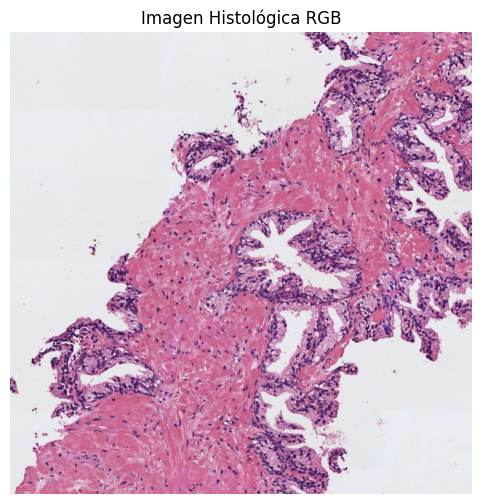

In [4]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB 
# (se utiliza io.imread)

# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1] (Se utiliza la 
# función img_as_float )
imagen_rgb = img_as_float(io.imread('histo_1.jpg'))

# Visualizar la imagen
plt.figure(figsize=(6,6))
plt.imshow(imagen_rgb)
plt.title('Imagen Histológica RGB')
plt.axis('off')
plt.show()


#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

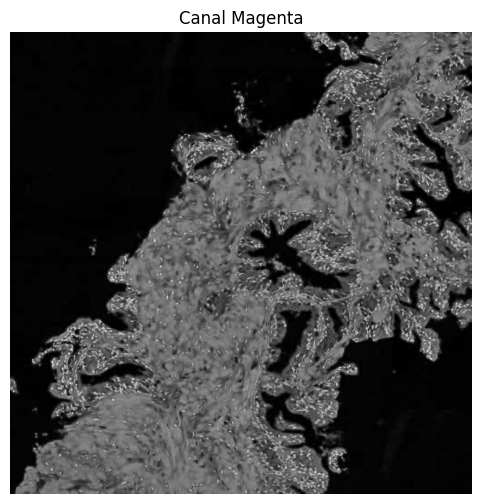

In [5]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta

# Convertir a CMYK y extraer canal magenta
def rgb_to_cmyk(rgb):
    # Asumo que la imagen tiene valores normalizados
    # Calculo los valores intermedios CMY (Cian, Magenta, Amarillo)
    # invirtiendo los valores RGB. Si RGB es (R,G,B), entonces CMY es (1-R, 1-G, 1-B)    
    cmy = 1 - rgb


     # Calculo el canal K (negro o Key).
    # En CMYK, K representa la cantidad de tinta negra pura.
    # Se obtiene como el mínimo de los canales CMY invertidos.
    # 'axis=2' significa que se toma el mínimo a lo largo de la tercera dimensión (los canales de color).
    # Por ejemplo, si CMY es (0, 1, 1), K sería min(0, 1, 1) = 0.
    # Si CMY fuera (0.5, 0.5, 0.5), K sería 0.5.
    k = np.min(cmy, axis=2)


    # Calculo los canales C, M, Y finales ajustados por el canal K.
    with np.errstate(invalid='ignore', divide='ignore'):

         # cmy[...,0] es el canal Cian intermedio.
        # Se resta K y se divide por (1 - K). Se añade un pequeño valor (1e-8) al divisor
        # para evitar la división por cero cuando (1 - K) sea cero (lo que ocurre si K es 1, es decir, negro puro).
        c = (cmy[...,0] - k) / (1 - k + 1e-8)

        # Similarmente para el canal Magenta.
        m = (cmy[...,1] - k) / (1 - k + 1e-8)

        # Similarmente para el canal Amarillo.
        y = (cmy[...,2] - k) / (1 - k + 1e-8)
    return c, m, y, k


# Llamo a la función rgb_to_cmyk pasando la imagen RGB normalizada (imagen_rgb).
# La función devuelve 4 valores (C, M, Y, K).
# Utilizo el desempaquetado de tuplas para ignorar
# los canales Cian, Amarillo y Negro, y solo almacenar el canal Magenta en la variable `magenta`.
_, magenta, _, _ = rgb_to_cmyk(imagen_rgb)

# Visualizo la imagen del canal magenta
plt.figure(figsize=(6,6))
plt.imshow(magenta, cmap='gray')
plt.title('Canal Magenta')
plt.axis('off')
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

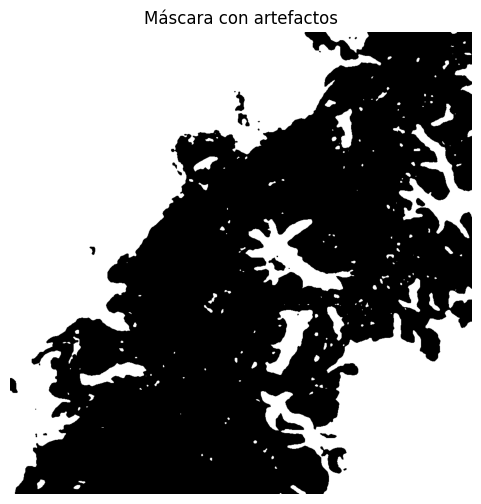

In [6]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante


# Aplico un filtro Gaussiano a la imagen. Un filtro Gaussiano es un filtro de paso bajo que se utiliza para 
# suavizar la imagen y reducir el ruido. 
mag_gauss = gaussian(magenta, sigma=2)  # kernel aproximado 5x5 sigma≈2

#Convierte la imagen de entrada (en este caso, mag_gauss, que tiene valores flotantes) a un tipo
#de dato de entero sin signo de 8 bits (uint8),
#escalando sus valores al rango [0, 255].
mag_u8 = img_as_ubyte(mag_gauss)

#Implemento el método de Otsu para la umbralización automática.
th = threshold_otsu(mag_u8)

#Creo una máscara binaria inicial
#Comparo cada píxel de la imagen mag_u8 (la imagen suavizada y en uint8) con el th (el umbral de Otsu).
mascara = mag_u8 > th

#Invierto: lumen + fondo = True
mascara_con_artefactos = np.logical_not(mascara)

plt.figure(figsize=(6,6))
plt.imshow(mascara_con_artefactos, cmap='gray')
plt.title('Máscara con artefactos')
plt.axis('off')
plt.show()


#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

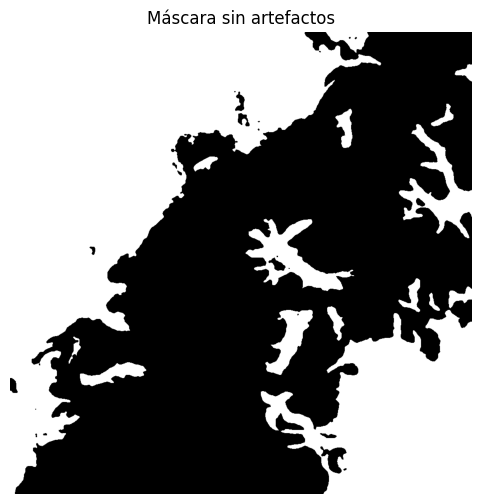

In [7]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizar la máscara resultante

# Elimino áreas menores a 300 píxeles
mascara_sin_artefactos = remove_small_objects(mascara_con_artefactos, min_size=300)

# Visualizo la máscara resultante
plt.figure(figsize=(6,6))
plt.imshow(mascara_sin_artefactos, cmap='gray')
plt.title('Máscara sin artefactos')
plt.axis('off')
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

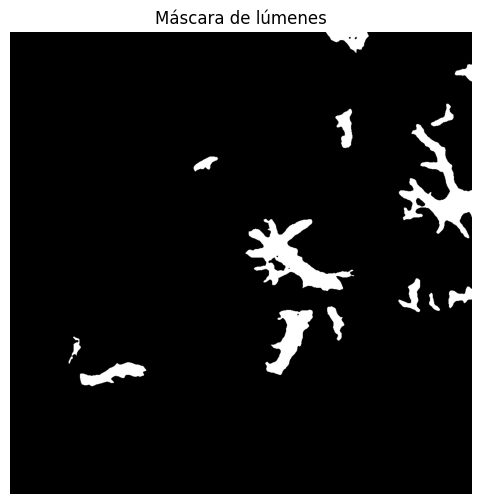

In [8]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante. 


# Region growing para aislar lúmenes
# Por ejemplo, elegimos semillas automáticas en zonas blancas exteriores

# Obtengo una tupla que representa las dimensiones de la imagen (alto, ancho)
h, w = mascara_sin_artefactos.shape

# Utilizo 2 semillas (Una semilla es un punto de inicio para el algoritmo de crecimiento de región)
#(0, 0) se refiere a la esquina superior izquierda de la imagen (fila 0, columna 0).
sem1 = (0, 0)
# (h-1, w-1) se refiere a la esquina inferior derecha de la imagen. h-1 es 
# la última fila y w-1 es la última columna.
sem2 = (h-1, w-1)

#Implemento el algoritmo de relleno por inundación (flood fill)
reg1 = flood(mascara_sin_artefactos, sem1)
reg2 = flood(mascara_sin_artefactos, sem2)


#Creo una nueva máscara llamada fondo. Un píxel en fondo será True si es True en reg1 o True 
#en reg2 (o en ambos). Esto esencialmente une las dos regiones de fondo identificadas desde las esquinas, 
#creando una máscara que representa la totalidad del "background" conectado a los bordes de la imagen.
fondo = reg1 | reg2

#Máscara binaria donde solo los píxeles correspondientes a los lúmenes son True (1), 
#y todo lo demás (fondo y tejido) es False (0).
mascara_de_lumenes = mascara_sin_artefactos & ~fondo

# Visualizo la máscara resultante. 
plt.figure(figsize=(6,6))
plt.imshow(mascara_de_lumenes, cmap='gray')
plt.title('Máscara de lúmenes')
plt.axis('off')
plt.show()

#### 5) Rellenar los objetos de los lúmenes

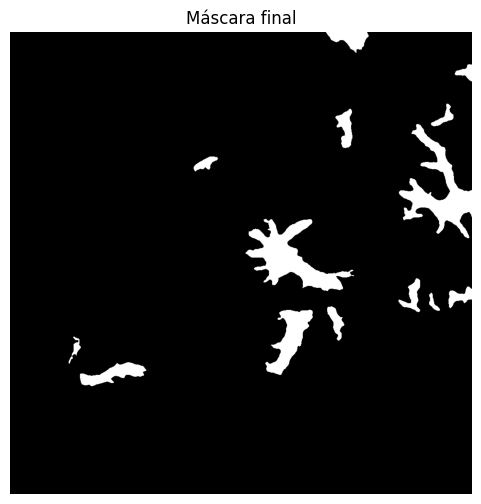

In [9]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante

# Relleno agujeros
mascara_final = binary_fill_holes(mascara_de_lumenes)

# Visualizo la máscara resultante
plt.figure(figsize=(6,6))
plt.imshow(mascara_final, cmap='gray')
plt.title('Máscara final')
plt.axis('off')
plt.show()


#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

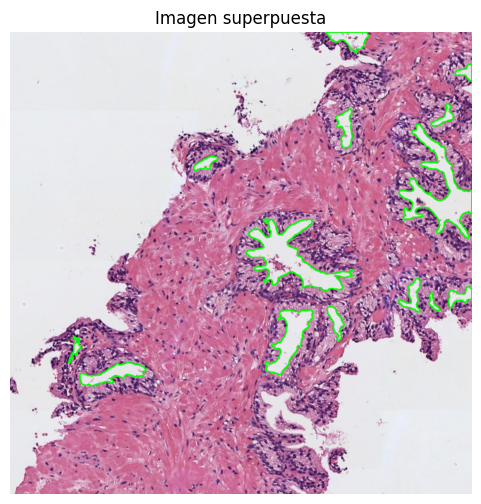

In [10]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Visualizar la imagen superpuesta


# Dibujo contornos sobre la imagen original
contornos, _ = cv2.findContours(mascara_final.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#Preparo una copia de la imagen original (escalándola de nuevo a 0-255 y convirtiéndola a uint8).
imagen_superpuesta = (imagen_rgb * 255).astype(np.uint8).copy()
#Dibujo los contornos detectados en color verde sobre la copia de la imagen original
cv2.drawContours(imagen_superpuesta, contornos, -1, (0,255,0), 2)  # Establezco el verde

# Visualizo la imagen superpuesta
plt.figure(figsize=(6,6))
plt.imshow(imagen_superpuesta)
plt.title('Imagen superpuesta')
plt.axis('off')
plt.show()

#### 7) Identificar y cropear el lumen más grande

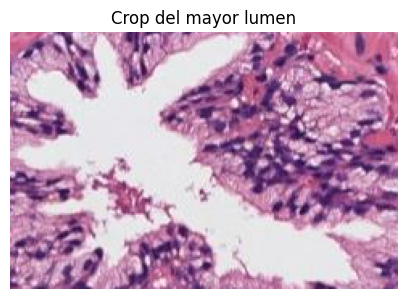

In [11]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

# Cropear el lumen más grande

# Examina los píxeles blancos (o True) en mascara_final. 
# A cada lumen individual en este caso se le asigna un número entero único ("etiqueta")
# etq: Variable que almacena la imagen etiquetada. Es un array donde cada píxel tiene
# un valor que indica a qué objeto (lumen) pertenece, o 0 si es fondo.
etq = label(mascara_final)

# regionprops(): calcula una variedad de propiedades geométricas y estadísticas para 
# cada región etiquetada en la imagen.
props = regionprops(etq)

# Si se encontró al menos un lumen
if props:
    mayor = max(props, key=lambda x: x.area)
    minr,minc,maxr,maxc = mayor.bbox
    crop_mayor_lumen = imagen_rgb[minr:maxr, minc:maxc]
    plt.figure(figsize=(5,5))
    plt.imshow(crop_mayor_lumen)
    plt.title('Crop del mayor lumen')
    plt.axis('off')
    # conservo también mask_crop si necesito
    mask_crop = etq[minr:maxr,minc:maxc]==mayor.label    
    plt.show()
else:
    print("No se encontraron lúmenes.")


#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [12]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad


# Extraigo 13 características geométricas del lumen más grande
from skimage.measure import perimeter

if props:
    area = mayor.area
    bbox_area = mayor.bbox_area
    area_convexa = mayor.convex_area
    excentricidad = mayor.eccentricity
    # diámetro equivalente: diámetro del círculo de misma área
    diam_equiv = np.sqrt(4*area/np.pi)
    extension = area / bbox_area
    feret_diameter = mayor.feret_diameter_max if hasattr(mayor, 'feret_diameter_max') else np.nan
    eje_mayor = mayor.major_axis_length
    eje_menor = mayor.minor_axis_length
    orientation = mayor.orientation
    perim = mayor.perimeter
    solidez = area / area_convexa
    # compacidad = perim**2 / area  (4 * np.pi * area)
    compacidad = perim**2 / (4 * np.pi * area) 
    
    caracteristicas = {
        'Área': area,
        'Área bounding box': bbox_area,
        'Área convexa': area_convexa,
        'Excentricidad': excentricidad,
        'Diámetro equivalente': diam_equiv,
        'Extensión': extension,
        'Diámetro Feret': feret_diameter,
        'Eje mayor': eje_mayor,
        'Eje menor': eje_menor,
        'Orientación': orientation,
        'Perímetro': perim,
        'Solidez': solidez,
        'Compacidad': compacidad
    }

    print("Características del lumen más grande:\n")
    i = 1
    for k,v in caracteristicas.items():
        print(f"{i}) {k}: {np.round(v,4)}")
        i = i+1

Características del lumen más grande:

1) Área: 13915.0
2) Área bounding box: 38560.0
3) Área convexa: 28424.0
4) Excentricidad: 0.8468
5) Diámetro equivalente: 133.1057
6) Extensión: 0.3609
7) Diámetro Feret: 253.6927
8) Eje mayor: 236.4714
9) Eje menor: 125.7639
10) Orientación: 0.9984
11) Perímetro: 1146.3067
12) Solidez: 0.4896
13) Compacidad: 7.5146
